# Blasé 3D [EXPERIMENTAL]

Here we experiment with a highly requested feature, which is cloning spectra across all nodes in a precomputed model grid.

In [1]:
import torch
from blase.emulator import SparseLinearEmulator
from gollum.phoenix import PHOENIXSpectrum, PHOENIXGrid
%matplotlib inline
%config InlineBackend.figure_format='retina'

Woohoo! You have PyTorch version 2.0.1


In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

### Set the wavelength limits

We will target a relatively narrow chunk of spectrum: $11000 - 11180$ Å.  We use a $60$ Å buffer to deal with edge effects.

In [3]:
wl_lo = 11_000-60
wl_hi = 11_180+60

## Read in a precomputed synthetic stellar spectrum

The [gollum](http://gollum-astro.readthedocs.io) precomputed synthetic spectral model interface makes this step pretty straightforward.  You don't even need to have the file locally-- gollum can fetch it for you.

In [4]:
stellar_spectrum = PHOENIXSpectrum(teff=4700, logg=4.5, 
                                   wl_lo=wl_lo, wl_hi=wl_hi, download=True)

In [5]:
mini_grid = PHOENIXGrid(teff_range=(4700, 4800), logg_range=(3, 3.5), Z_range=(0, 0), wl_lo=wl_lo, wl_hi=wl_hi, download=True)

Processing Teff=4800K|log(g)=3.50|Z=+0.0: 100%|██████████| 4/4 [00:00<00:00, 30.27it/s]


In [6]:
def preprocess(stellar_spectrum):
    stellar_spectrum = stellar_spectrum.divide_by_blackbody()
    stellar_spectrum = stellar_spectrum.normalize()
    continuum_fit = stellar_spectrum.fit_continuum(polyorder=5)
    stellar_spectrum = stellar_spectrum.divide(continuum_fit, handle_meta="ff")
    return stellar_spectrum

The pristine PHOENIX spectrum needs to be flattened to facilitate line finding:  We first divide out the black body and then divide by a $5^{th}$ order polynomial.

In [7]:
clean_grid = [preprocess(mini_grid[i]) for i in range(mini_grid.n_spectra)]

In [20]:
emulators = [SparseLinearEmulator(cleanspec.wavelength.value, cleanspec.flux.value, wing_cut_pixels=6000, prominence=0.005) for cleanspec in clean_grid]
for emulator in emulators:
    emulator.to(device)
    emulator.optimize(epochs=200, LR=0.03)

c:\users\sujay\documents\github\blase3d\src\blase\emulator.py:380: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.target = torch.tensor(


Initializing a sparse model with 498 spectral lines
Initializing a sparse model with 515 spectral lines
Initializing a sparse model with 488 spectral lines
Initializing a sparse model with 493 spectral lines


Training Loss: 0.00025308: 100%|██████████| 200/200 [00:11<00:00, 17.07it/s]


## Clone the stellar model

We make an emulator for the spectrum by cloning all of the spectral lines above some prominence threshold:

The emulator found hundreds of spectral lines through a [heuristic](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) process, and then instantiates a [Voigt profile](https://en.wikipedia.org/wiki/Voigt_profile) there.

In [21]:
from functools import reduce
import numpy as np

line_lists = [emulator.lam_centers.detach().to('cpu').numpy().round(2) for emulator in emulators]
common_lines = reduce(np.intersect1d, line_lists)

The `forward` pass of the model makes a spectrum that we can examine:

In [22]:
with torch.no_grad():
    stellar_pre = emulators[0].forward().to('cpu').numpy()

In [23]:
stellar_pre.max()

1.0

The initial guess should look lousy:

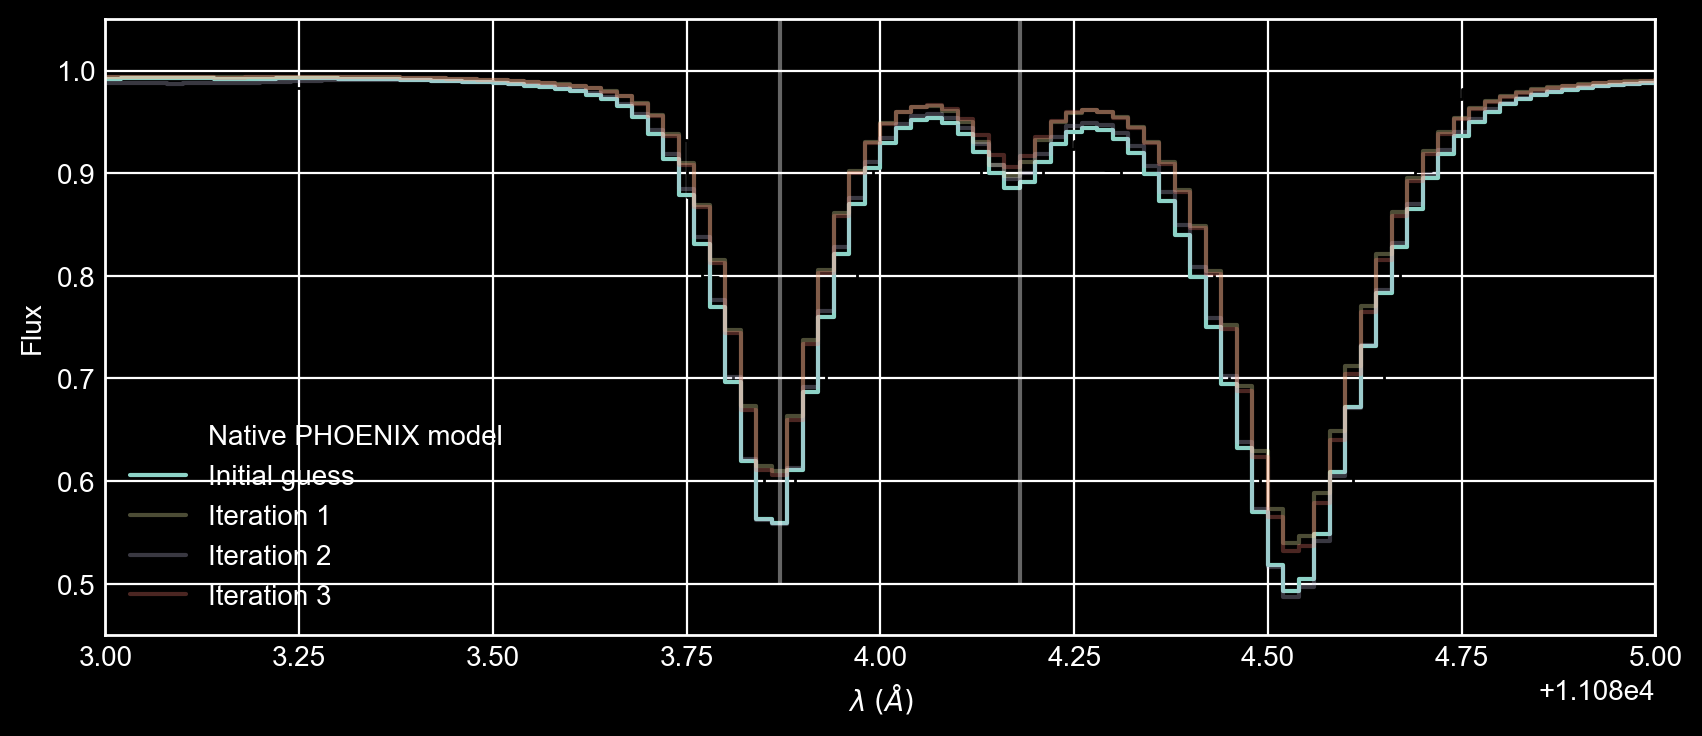

In [37]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
ax = mini_grid[0].plot(ylo=0.45, yhi=1.05, label='Native PHOENIX model', color='k')
ax.step(stellar_spectrum.wavelength.value, stellar_pre, label='Initial guess', zorder=2)
for i in range(1, 4):
    ax.step(mini_grid[i].wavelength.value, emulators[i].forward().detach().to('cpu').numpy(), label=f'Iteration {i}', zorder=2, alpha=0.3)
ax.vlines(common_lines, 0.5, 1.05, color='white', alpha=0.4)
ax.set_xlim(11_083, 11_085)
ax.legend();

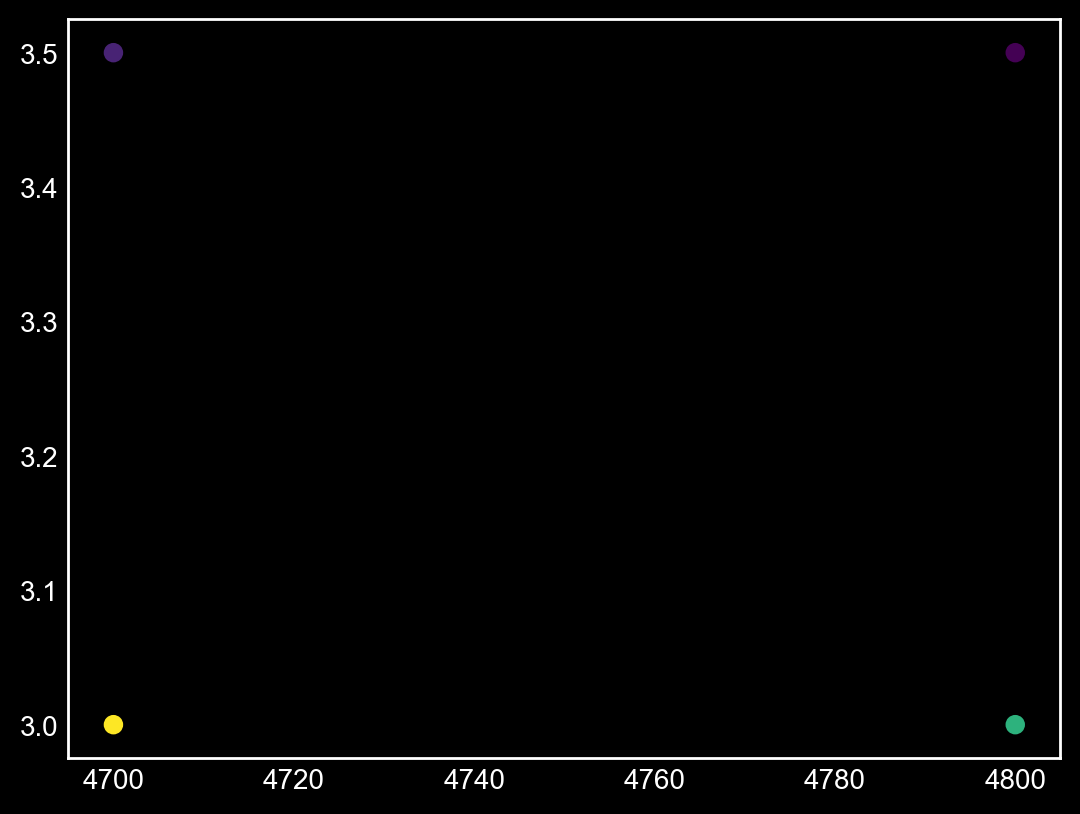

In [88]:
%matplotlib inline
points = np.array(mini_grid.grid_points)[:,:2]
plt.scatter(points[:,0], points[:,1], c=amps, cmap='viridis')
plt.grid(False)

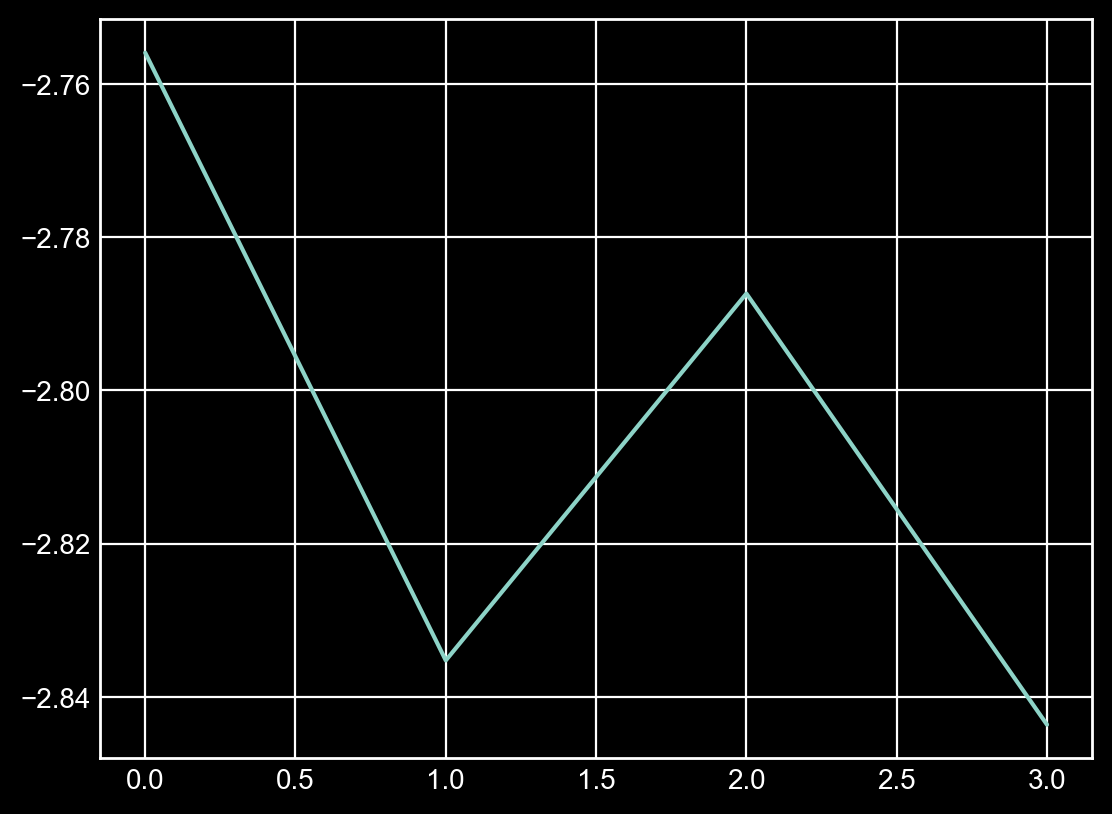

In [87]:
#emulators[0].amplitudes[emulators[0].lam_centers.detach().to('cpu').numpy() > 45000, emulators[0].lam_centers.detach().to('cpu').numpy() < 46000]
amps = [em.sigma_widths[4].detach().cpu().numpy() for em in emulators]
plt.plot(amps)

The initialization is terrible! It's just a coarse guess that there is a line there with an approximate width and depth.  In the next step we will fine tune that guess.

### Fine-tune the model to clone the spectrum to near pixel-perfect

Here we adjust all of the properties of the lines simultaneously with the [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) algorithm built into PyTorch.  Here we choose the bare minimum of 20 epochs with an aggressive learning rate (LR) of 0.05.  You should be able to get a better fit by running it for say 300 epochs, with a learning rate (LR) of 0.01, for example.  But it would take much longer.

In [12]:
stellar_emulator.optimize(epochs=100, LR=0.05)

NameError: name 'stellar_emulator' is not defined

Now we can examine the spectrum, post fine-tuning.  It should provide a *much* better fit:

In [ ]:
with torch.no_grad():
    stellar_post = stellar_emulator.forward().cpu().numpy()

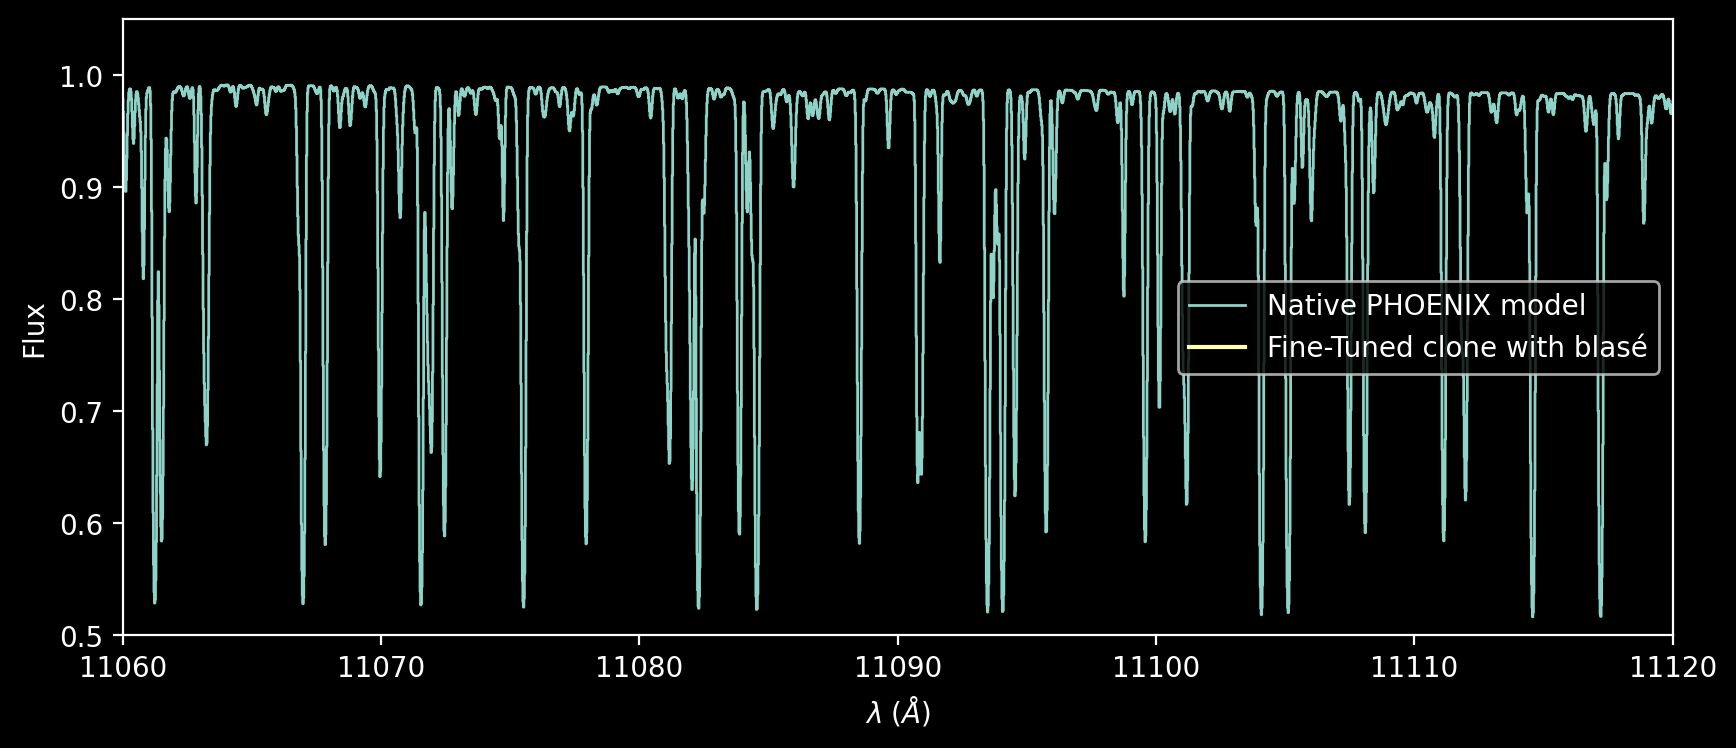

In [ ]:
ax = mini_grid[0].plot(ylo=0.5, yhi=1.05, label='Native PHOENIX model')
ax.step(stellar_spectrum.wavelength.value, stellar_post, label='Fine-Tuned clone with blasé')
ax.set_xlim(11_060, 11_120)
ax.legend();

Voilá! It's not perfect, but it's much better than before.  And recall that this is the clone at *native* resolution and pixel sampling.  Most models will ultimately be convolved with an instrumental kernel that will wash away most of these imperfections.

## Saving fine-tuned parameters as a "lookup table"

The collection of values for the wavelength centers, amplitudes, Gaussian widths, Lorentzian widths, and other parameters represents a reproducible snapshot of the model state:

> If you hand me the "lookup table" of these parameters, I can recreate the entire cloned forward model.  

In [ ]:
torch.save(stellar_emulator.state_dict(), "phoenix_clone_T4700g4p5_prom0p01_11000Ang.pt")